# Generate wordclouds for clusters

### Import libraries

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import pandas as pd
from wordcloud import WordCloud
import numpy as np

### Function for wordclouds

In [24]:
def generate_wordclouds(
    df, cluster_column, text_column, stop_words, max_words=100, top_n=10
):
    """
    Generates word clouds and displays them side-by-side in a grid layout with cluster stats in titles.
    
    Parameters:
    - df: DataFrame containing text and cluster labels.
    - cluster_column: Column with cluster labels.
    - text_column: Column with text to analyze.
    - tfidf_matrix: Optional precomputed TF-IDF matrix.
    - vectorizer: Pre-fitted vectorizer associated with the TF-IDF matrix.
    - max_words: Max words in word cloud.
    - top_n: Number of top terms to display.

    Returns:
    - None
    """
    
    # Create TF-IDF matrix
    vectorizer = TfidfVectorizer(max_features=10000, stop_words=stop_words)
    tfidf_matrix = vectorizer.fit_transform(df[text_column])

    feature_names = vectorizer.get_feature_names_out()

    # Identify unique clusters
    clusters = df[cluster_column].unique()
    n_clusters = len(clusters)

    # Create subplots (grid with 2 columns)
    cols = 2
    rows = (n_clusters + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 5))
    axes = axes.flatten()

    for i, cluster in enumerate(clusters):
        cluster_indices = df[cluster_column] == cluster
        
        # Compute average sentiment, LIX, and upvotes
        avg_sentiment = df.loc[cluster_indices, "sentiment_score"].mean()
        avg_lix = df.loc[cluster_indices, "lix_score"].mean()
        avg_upvotes = df.loc[cluster_indices, "upvotes"].mean()
        
        # Format cluster statistics for the title
        stats_title = (
            f"Cluster {cluster}\n"
            f"Sentiment: {avg_sentiment:.2f}, LIX: {avg_lix:.2f}, Upvotes: {avg_upvotes:.1f}"
        )
        
        # Generate TF-IDF scores
        tfidf_scores = tfidf_matrix[cluster_indices].sum(axis=0).A1
        tfidf_dict = dict(zip(feature_names, tfidf_scores))
        
        # Display top terms
        top_terms = sorted(tfidf_dict.items(), key=lambda x: x[1], reverse=True)[:top_n]
        print(f"\nCluster {cluster}: Top {top_n} Terms\n" + ", ".join(f"{term} ({score:.2f})" for term, score in top_terms))
        
        # Generate word cloud
        wordcloud = WordCloud(
            width=600, height=400, background_color="black", colormap="viridis", max_words=max_words
        ).generate_from_frequencies(tfidf_dict)
        
        # Plot on the appropriate subplot
        ax = axes[i]
        ax.imshow(wordcloud, interpolation="bilinear")
        ax.axis("off")
        ax.set_title(stats_title, fontsize=12, color="black")

    # Hide any unused subplot axes
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    # Adjust layout for better spacing
    plt.subplots_adjust(wspace=0.3, hspace=0.4)
    plt.tight_layout()
    plt.show()

### Plotting wordclouds for the clusters


Cluster 3: Top 10 Terms
like (13.28), people (9.89), good (8.58), un (8.17), time (8.14), going (7.74), want (7.17), something (6.27), one (6.26), right (6.23)

Cluster 2: Top 10 Terms
going (3.83), really (3.67), people (3.36), sure (3.03), good (3.00), world (2.78), money (2.59), it (2.50), guess (2.44), bibi (2.35)

Cluster 4: Top 10 Terms
war (17.96), people (16.02), attack (12.51), terrorists (10.63), terrorist (9.66), one (9.10), world (9.00), even (8.17), like (7.95), said (7.82)

Cluster 0: Top 10 Terms
war (14.73), terrorists (11.49), people (11.30), hostages (9.62), one (7.78), country (7.51), going (7.47), un (6.46), want (6.33), state (6.19)

Cluster 1: Top 10 Terms
like (11.33), people (7.83), un (7.72), good (7.26), well (6.42), country (5.95), world (5.70), support (5.64), peace (5.39), hostages (5.39)


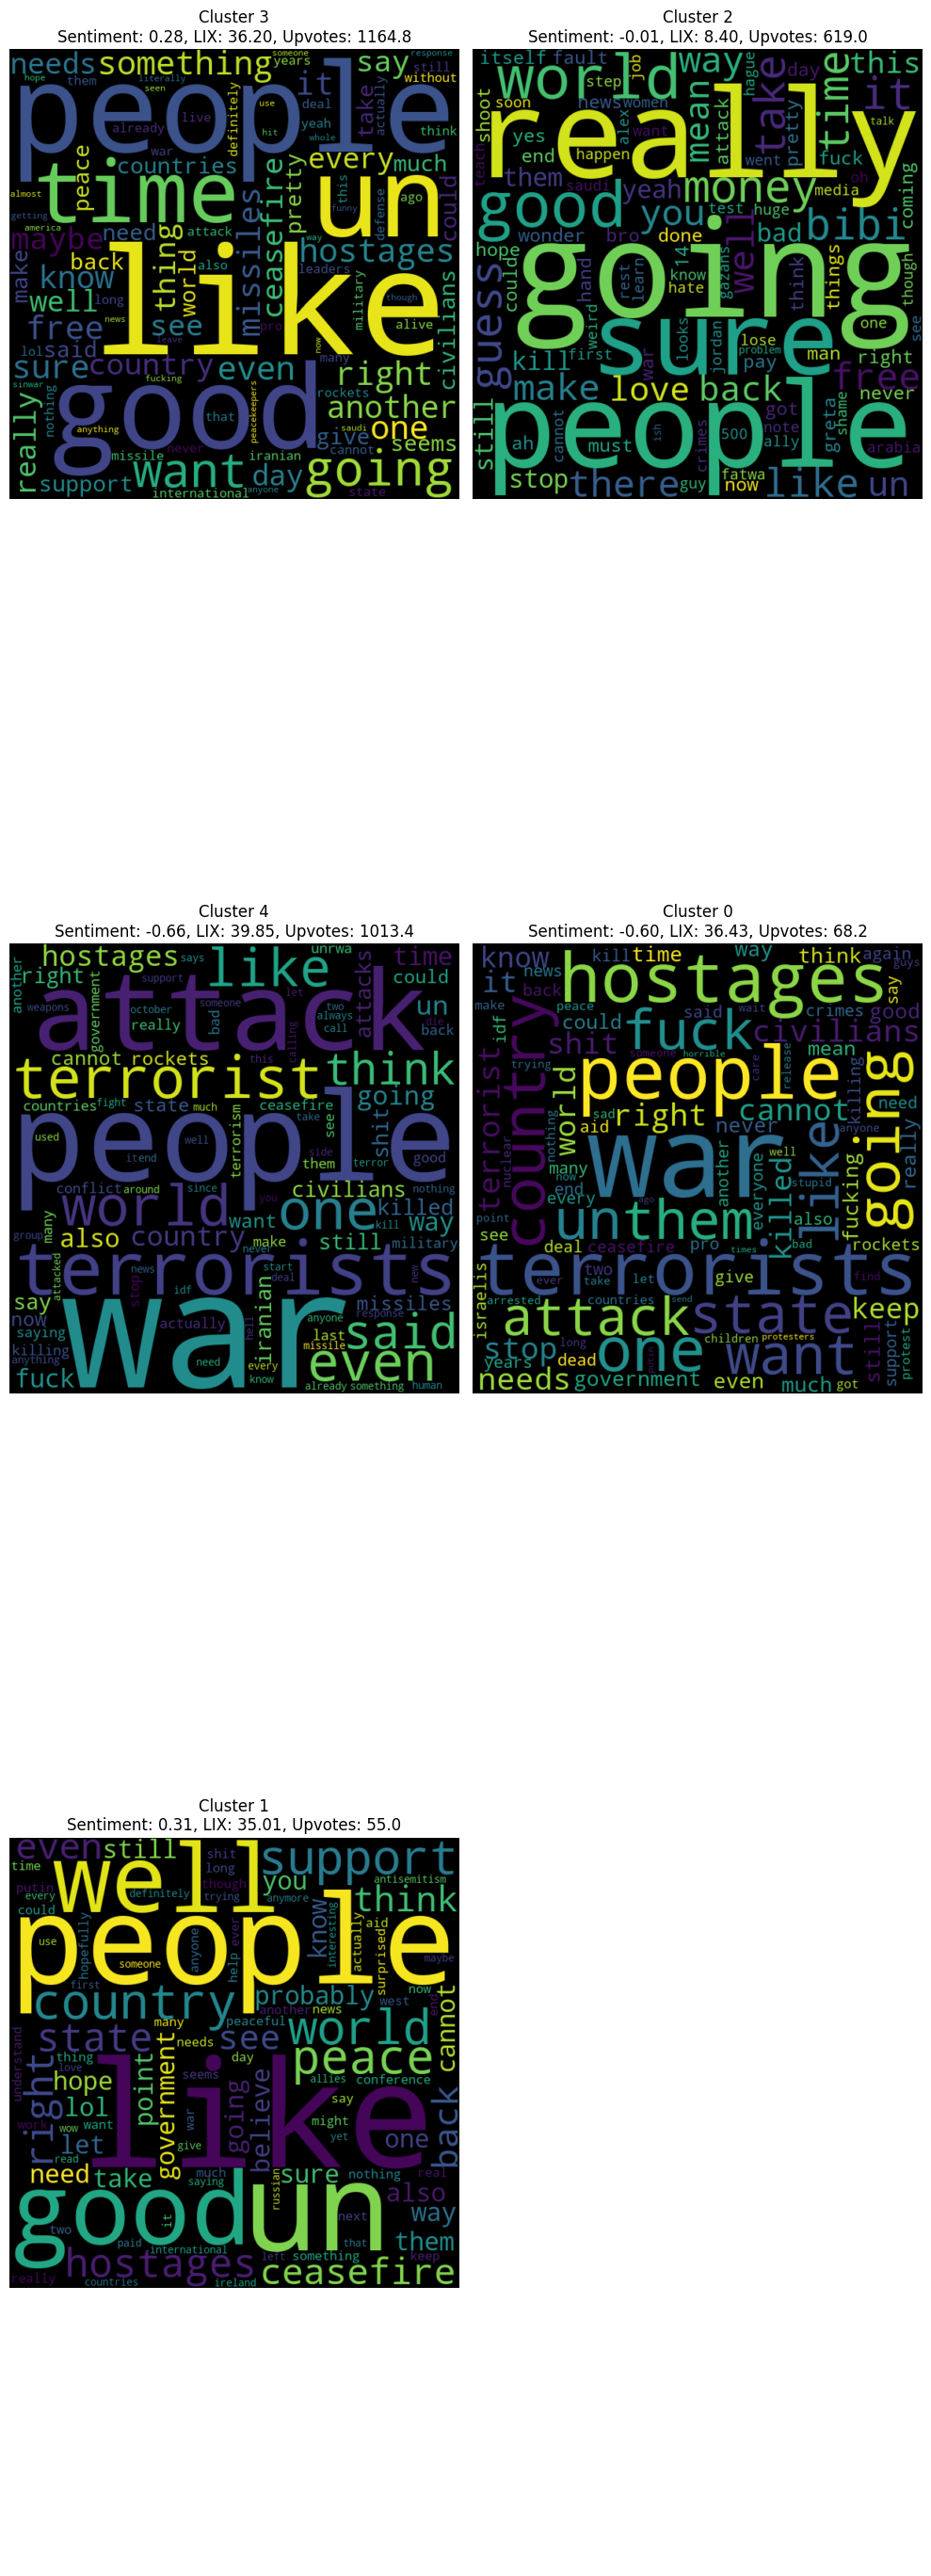

                sentiment_score  lix_score      upvotes
kmeans_cluster                                         
0                     -0.601143  36.426466    68.214397
1                      0.310428  35.008736    55.018550
2                     -0.007972   8.395760   618.966184
3                      0.283660  36.198545  1164.779661
4                     -0.657356  39.847969  1013.379924


In [ ]:
# Choose subreddit
subreddit = "worldnews"

# Load the data
df = pd.read_csv(f"data/{subreddit}_clustered.csv")
df = df.dropna()

if subreddit == "baking":
    generate_wordclouds(
    df,
    cluster_column="kmeans_cluster",
    text_column="comment_no_stopwords",
    stop_words="english",
    max_words=100,
    top_n=10
    )
    
    cluster_stats = df.groupby('kmeans_cluster')[['sentiment_score', 'lix_score', 'upvotes']].mean()
    print(cluster_stats)

else:
    custom_stopwords = ["israel", "palestine", "hamas", "israeli", "jewish", "arab", "arabs", "palestinian", "iran", "palestinians", "gaza", "hezbollah", "trump", "biden", "bernie", "us", "go", "ukraine", "netanyahu", "jews", "germany", "lebanon", "russia", "zionists", "zionist", "would", "get"]
    # custom_stopwords = 'english'
    generate_wordclouds(
        df,
        cluster_column="kmeans_cluster",
        text_column="comment_no_stopwords",
        stop_words=custom_stopwords,
        max_words=100,
        top_n=10
    )

    cluster_stats = df.groupby('kmeans_cluster')[['sentiment_score', 'lix_score', 'upvotes']].mean()
    print(cluster_stats)
